In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
scaler = StandardScaler()
data = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_round2.csv')
data_validation = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/validation_data.csv')
data_validation_1 = data_validation.drop(columns=['sub_H','sub_B','yield'])
# model = SVR(C= 64.51362485554927, epsilon= 0.017764809329630676, gamma= 4.087196842905059)
model = SVR(C= 63.91726535154404, epsilon= 0.01666549751396613, gamma= 5.275057481551831)
data1 = data[['Mulliken_charge_H_H', 'APT_charge_H_H', 'NICS1', 'delta_G_B', 'lumo_B','yield']]
display(data1)
display(data_validation_1)

,Mulliken_charge_H_H,APT_charge_H_H,NICS1,delta_G_B,lumo_B,yield
0,0.033376,0.073939,9.8110,6.2,0.03041,56
1,0.063562,0.097075,8.7917,9.5,0.06388,3
2,0.026258,0.066299,9.7147,6.2,0.03041,39
3,0.049506,-0.031899,9.7644,6.2,0.03041,4
4,0.031469,0.073363,10.2984,9.7,0.03702,54
...,...,...,...,...,...,...
83,0.038094,0.090742,-8.6273,6.2,0.03041,0
84,0.036865,0.078824,-10.0335,14.2,0.02990,22
85,0.036865,0.078824,-10.0335,9.5,0.06388,23
86,0.015193,0.057754,-9.7614,6.2,0.03041,41


,Mulliken_charge_H_H,APT_charge_H_H,NICS1,delta_G_B,lumo_B
0,0.033376,0.073939,9.8110,6.2,0.03041
1,0.033376,0.073939,9.8110,9.5,0.06388
2,0.033376,0.073939,9.8110,9.7,0.03702
3,0.033376,0.073939,9.8110,14.2,0.02990
4,0.033376,0.073939,9.8110,3.0,0.06937
...,...,...,...,...,...
715,0.036745,0.107653,9.6114,3.0,0.06937
716,0.036745,0.107653,9.6114,-0.2,0.06623
717,0.036745,0.107653,9.6114,10.2,0.06897
718,0.036745,0.107653,9.6114,4.4,0.07122


In [29]:


import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

features = data1.select_dtypes(include=[np.number]).columns
X = data1[features].drop('yield', axis=1)
display(X)
y = data1['yield']
y_pred_list = []
mae_list = []  
mse_list = []
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler(feature_range=(0, 100))
scaler_X.fit(X)  # data1 的特征
scaler_y.fit(y.values.reshape(-1,1))  # data1 的标签
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()

    model.fit(X_train_scaled, y_train_scaled)
    
    data_validation_1_scaled = scaler_X.transform(data_validation_1) # 外部验证总空间
    # display(data_validation_1_scaled)
    # display(data_validation_1)
    y_pred = model.predict(data_validation_1_scaled)
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
    y_pred = np.clip(y_pred, 0, 100) # 将预测值限制在0-100之间
    y_pred_list.append(y_pred)
    
    y_test_pred = model.predict(X_test_scaled) # 原空间
    y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
    y_test_pred = np.clip(y_test_pred, 0, 100) # 将预测值限制在0-100之间
    # mae = mean_absolute_error(y_test, y_test_pred)
    # mae_list.append(mae)
    mse = mean_squared_error(y_test, y_test_pred)
    mse_list.append(mse)


y_pred_array = np.array(y_pred_list)

# Calculate the weights, using the inverse of the mean square error
# weights = 1 / np.array(mae_list)
weights = 1 / np.array(mse_list)
weights /= np.sum(weights)  # Normalized weights

# Calculate weighted average forecast
y_pred_weighted = np.dot(weights, y_pred_array)

# Add y_pred as a new column to data_validation
data_validation_1['y_pred_mean'] = y_pred_weighted
data_validation_1 = pd.concat([data_validation[['sub_H', 'sub_B']], data_validation_1], axis=1)
display(data_validation_1)

data_validation_1.to_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_validation_weighted_mean.csv', index=False)


,Mulliken_charge_H_H,APT_charge_H_H,NICS1,delta_G_B,lumo_B
0,0.033376,0.073939,9.8110,6.2,0.03041
1,0.063562,0.097075,8.7917,9.5,0.06388
2,0.026258,0.066299,9.7147,6.2,0.03041
3,0.049506,-0.031899,9.7644,6.2,0.03041
4,0.031469,0.073363,10.2984,9.7,0.03702
...,...,...,...,...,...
83,0.038094,0.090742,-8.6273,6.2,0.03041
84,0.036865,0.078824,-10.0335,14.2,0.02990
85,0.036865,0.078824,-10.0335,9.5,0.06388
86,0.015193,0.057754,-9.7614,6.2,0.03041


,sub_H,sub_B,Mulliken_charge_H_H,APT_charge_H_H,NICS1,delta_G_B,lumo_B,y_pred_mean
0,A02,1c,0.033376,0.073939,9.8110,6.2,0.03041,48.020861
1,A02,1d,0.033376,0.073939,9.8110,9.5,0.06388,22.218612
2,A02,1b,0.033376,0.073939,9.8110,9.7,0.03702,50.356252
3,A02,1a,0.033376,0.073939,9.8110,14.2,0.02990,41.092523
4,A02,1i,0.033376,0.073939,9.8110,3.0,0.06937,26.058686
...,...,...,...,...,...,...,...,...
715,A36,1i,0.036745,0.107653,9.6114,3.0,0.06937,24.323439
716,A36,1j,0.036745,0.107653,9.6114,-0.2,0.06623,27.606702
717,A36,1g,0.036745,0.107653,9.6114,10.2,0.06897,17.963352
718,A36,1h,0.036745,0.107653,9.6114,4.4,0.07122,22.779493


In [30]:
df1 = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_validation_weighted_mean.csv')
df2 = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_round2.csv')

# Ensure that both DataFrames have sub_H and sub_B columns
if 'sub_H' not in df1.columns or 'sub_B' not in df1.columns:
    raise ValueError("First CSV file missing sub_H or sub_B columns")

if 'sub_H' not in df2.columns or 'sub_B' not in df2.columns:
    raise ValueError("Second CSV file missing sub_H or sub_B columns")

# Create a mapping dictionary with sub_H and sub_B as keys
mapping_dict = df1.set_index(['sub_H', 'sub_B'])['y_pred_mean'].to_dict()

# Add the y_pred_mean column to the second CSV file using the mapping dictionary
df2['y_pred_mean'] = df2.apply(lambda row: mapping_dict.get((row['sub_H'], row['sub_B']), None), axis=1)
display(df2)
# Save the results to a new CSV file
df2.to_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/final_with_y_pred_weighted_mean.csv', index=False)
print("Processing complete. Results saved to final_with_y_pred_weighted_mean.csv")


,sub_H,sub_B,pka_H,dipole_H,homo_H,lumo_H,electronegativity_H,Mulliken_charge_C_H,APT_charge_C_H,NPA_charge_C_H,...,NICS1,pka_B,delta_G_B,delta_G_B_TS,dipole_B,homo_B,lumo_B,electronegativity_B,yield,y_pred_mean
0,A02,1c,35.7,2.8417,-0.24992,0.00903,0.120445,0.085796,0.140415,0.01137,...,9.8110,36.3,6.2,17.4,1.3174,-0.28448,0.03041,0.127335,56,48.020861
1,A08,1d,25.1,1.2906,-0.29842,-0.00164,0.150030,0.212938,0.488911,0.43105,...,8.7917,33.1,9.5,19.5,1.0675,-0.29832,0.06388,0.117220,3,4.289252
2,A09,1c,37.2,2.5710,-0.27399,0.01399,0.130000,0.008631,-0.018231,-0.22526,...,9.7147,36.3,6.2,17.4,1.3174,-0.28448,0.03041,0.127335,39,43.356822
3,A10,1c,33.0,1.3368,-0.28121,0.02498,0.128115,-0.166815,-0.272209,-0.39805,...,9.7644,36.3,6.2,17.4,1.3174,-0.28448,0.03041,0.127335,4,22.969106
4,A12,1b,36.7,1.5137,-0.30418,0.01553,0.144325,-0.078094,-0.129575,-0.30117,...,10.2984,35.8,9.7,16.0,1.0548,-0.28379,0.03702,0.123385,54,49.926853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,S68,1c,36.5,1.4742,-0.26809,0.01008,0.129005,0.058416,0.117456,-0.03736,...,-8.6273,36.3,6.2,17.4,1.3174,-0.28448,0.03041,0.127035,0,51.302585
84,S69,1a,35.4,4.5313,-0.26009,0.00723,0.126430,0.071321,0.160073,0.01622,...,-10.0335,35.0,14.2,18.9,1.4392,-0.28457,0.02990,0.127335,22,38.863994
85,S69,1d,35.4,4.5313,-0.26009,0.00723,0.126430,0.071321,0.160073,0.01622,...,-10.0335,33.1,9.5,19.5,1.0675,-0.29832,0.06388,0.117220,23,23.136229
86,S70,1c,41.9,1.2909,-0.26504,0.02936,0.117840,-0.034773,-0.148247,-0.25978,...,-9.7614,36.3,6.2,17.4,1.3174,-0.28448,0.03041,0.127335,41,45.471948


Processing complete. Results saved to final_with_y_pred_weighted_mean.csv


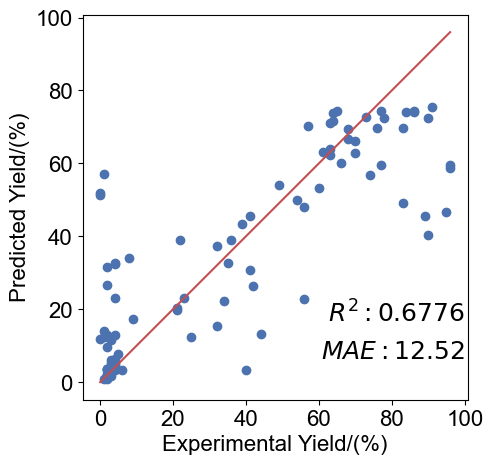

In [31]:
df3 = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/final_with_y_pred_weighted_mean.csv')

y_test = df3['yield']
y_pred = df3['y_pred_mean']

mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
# print(fr'R^2: {r2_test:.4f}')
# print(fr'MAE:{mae_test:.4f}')
# print(fr'RMSE: {rmse_test:.4f}')
# 限制子图大小
plt.figure(figsize=(5, 5))
plt.rcParams['font.sans-serif'] = ['Arial']
colors = sns.color_palette("deep")
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(y_test, y_pred, color=colors[0], label='Test' )
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color=colors[3], label='Perfect Prediction')
plt.xlabel('Experimental Yield/(%)', fontsize=16)
plt.ylabel('Predicted Yield/(%)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.text(100, 5, fr"$MAE: {mae_test:.2f}$", fontsize=18, ha='right', va='bottom')
# plt.text(100, 10, fr"$RMSE: {rmse_test:.2f}$", fontsize=18, ha='right', va='bottom')
plt.text(100, 15, fr"$R^2: {r2_test:.4f}$", fontsize=18, ha='right', va='bottom')
plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/prediction_weighted_mean.png',dpi=600,format='png',bbox_inches='tight')
plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/prediction_weighted_mean.tif',dpi=600,format='tif',bbox_inches='tight')
plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/prediction_weighted_mean.eps',format='eps',bbox_inches='tight')
# 保存为pdf
plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/prediction_weighted_mean.pdf',format='pdf',bbox_inches='tight')
# 保存为svg
plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/prediction_weighted_mean.svg',format='svg',bbox_inches='tight')
# 保存为emf
# plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/prediction_weighted_mean.emf',format='wmf',bbox_inches='tight')
plt.show()


Processing complete. Results saved to final_with_y_pred_mean.csv


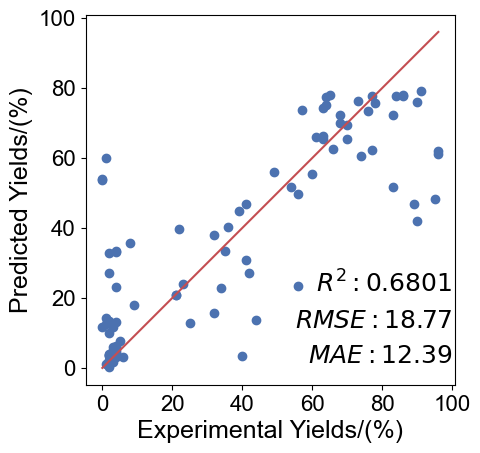

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
scaler = StandardScaler()
data = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_round2.csv')
data_validation = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/validation_data.csv')
data_validation_1 = data_validation.drop(columns=['sub_H','sub_B','yield'])
model = SVR(C= 63.91726535154404, epsilon= 0.01666549751396613, gamma= 5.275057481551831)
data1 = data[['Mulliken_charge_H_H', 'APT_charge_H_H', 'NICS1', 'delta_G_B', 'lumo_B','yield']]

features = data1.select_dtypes(include=[np.number]).columns
X = data1[features].drop('yield', axis=1)
y = data1['yield']
y_pred_list = []
y_pred_weighted_list = []
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler(feature_range=(0, 100))
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(scaler_X.transform(data_validation_1))
    y_pred_list.append(y_pred)

# Output the number of rows of data_validation
import numpy as np
# Convert predictions to numpy arrays
y_pred_array = np.array(y_pred_list)
# Averaging of forecasts
y_pred_avg = np.mean(y_pred_array, axis=0)
data_validation_2 = data_validation_1
data_validation_2['y_pred_mean'] = y_pred_avg
data_validation_2 = pd.concat([data_validation[['sub_H', 'sub_B']], data_validation_2], axis=1)
data_validation_2.to_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_validation_mean.csv', index=False)



df1 = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_validation_mean.csv')
df2 = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_round2.csv')

# Ensure that both DataFrames have sub_H and sub_B columns
if 'sub_H' not in df1.columns or 'sub_B' not in df1.columns:
    raise ValueError("First CSV file missing sub_H or sub_B columns")

if 'sub_H' not in df2.columns or 'sub_B' not in df2.columns:
    raise ValueError("Second CSV file missing sub_H or sub_B columns")

# Create a mapping dictionary with sub_H and sub_B as keys
mapping_dict = df1.set_index(['sub_H', 'sub_B'])['y_pred_mean'].to_dict()

df2['y_pred_mean'] = df2.apply(lambda row: mapping_dict.get((row['sub_H'], row['sub_B']), None), axis=1)
df2.to_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/final_with_y_pred_mean.csv', index=False)
print("Processing complete. Results saved to final_with_y_pred_mean.csv")

df3 = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/final_with_y_pred_mean.csv')
y_test = df3['yield']
y_pred = df3['y_pred_mean']

# results charts

mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
# print(fr'R^2: {r2_test:.4f}')
# print(fr'MAE:{mae_test:.4f}')
# print(fr'RMSE: {rmse_test:.4f}')
colors = sns.color_palette("deep")
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(y_test, y_pred, color=colors[0], label='Test' )
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color=colors[3], label='Perfect Prediction')
plt.xlabel('Experimental Yields/(%)', fontsize=18)
plt.ylabel('Predicted Yields/(%)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.text(100, 0, fr"$MAE: {mae_test:.2f}$", fontsize=18, ha='right', va='bottom')
plt.text(100, 10, fr"$RMSE: {rmse_test:.2f}$", fontsize=18, ha='right', va='bottom')
plt.text(100, 20, fr"$R^2: {r2_test:.4f}$", fontsize=18, ha='right', va='bottom')
plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/prediction_mean.png',dpi=600,format='png',bbox_inches='tight')
plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/prediction_mean.tif',dpi=600,format='tif',bbox_inches='tight')
plt.show()


In [33]:
# 调用模型，采用不同的随机数划分方式预测，并通过visualization可视化预测结果

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
# from visualization import plot_scatter_standard

# model_data = joblib.load('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/models/SVR/SVR_final_20250321_110824.joblib')
# model = model_data['model']
model = SVR(C= 63.91726535154404, epsilon= 0.01666549751396613, gamma= 5.275057481551831)
# data = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/data_new.csv')

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler(feature_range=(0, 100))

data = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/data_round2.csv')
data = data[['Mulliken_charge_H_H', 'APT_charge_H_H', 'NICS1', 'delta_G_B', 'lumo_B','yield']]
features = data.select_dtypes(include=[np.number]).columns
X = data[features].drop('yield', axis=1)
# X = X.drop(columns=['sub_H']) # 删除作为序列的sub_H列
y = data['yield']
target_original = pd.read_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/validation_data.csv')
target = target_original.drop(columns=['sub_H','sub_B','yield'])
display(target)
display(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

# # 只保留model_data['final_features']中的特征
# X_train = X_train[model_data['features']]
# X_test = X_test[model_data['features']]
# Plot final scatter plot for this model
# Get predictions for train and test sets
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
target_scaled = scaler_X.transform(target)
# Train model with final parameters
model.fit(X_train_scaled, y_train_scaled)

# Get predictions
y_pred_train_scaled = model.predict(X_train_scaled)
y_pred_test_scaled = model.predict(X_test_scaled)
y_pred_target_scaled = model.predict(target_scaled)
# Inverse transform predictions
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()
y_pred_target = scaler_y.inverse_transform(y_pred_target_scaled.reshape(-1, 1)).ravel()

# Ensure predictions are within valid range
y_pred_train = np.clip(y_pred_train, 0, 100)
y_pred_test = np.clip(y_pred_test, 0, 100)
y_pred_target = np.clip(y_pred_target, 0, 100)

print(y_pred_target)

# 将y_pred_target列保留，与原来的target合并，保存为csv文件
target_original['y_pred_mean'] = y_pred_target
target_original.to_csv('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/round2_output/model1/target_with_y_pred_mean.csv', index=False)

# mae_test = mean_absolute_error(y_test, y_pred_test)
# r2_test = r2_score(y_test, y_pred_test)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# colors = sns.color_palette("deep")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.scatter(y_test, y_pred_test, color=colors[0], label='Test' )
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color=colors[3], label='Perfect Prediction')
# plt.xlabel('Experimental Yield', fontsize=18)
# plt.ylabel('Predicted Yield', fontsize=18)
# plt.grid(False)
# plt.text(100, 0, fr"$MAE: {mae_test:.2f}$", fontsize=18, ha='right', va='bottom')
# plt.text(100, 10, fr"$RMSE: {rmse_test:.2f}$", fontsize=18, ha='right', va='bottom')
# plt.text(100, 20, fr"$R^2$: {r2_test:.4f}", fontsize=18, ha='right', va='bottom')
# plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/prediction_mean_direct.png',dpi=600,format='png',bbox_inches='tight')
# plt.savefig('/home/ldj/Code/Projects/Stable-Organoboronates-ML-Supp/prediction_mean_direct.tif',dpi=600,format='tif',bbox_inches='tight')
# plt.show()





,Mulliken_charge_H_H,APT_charge_H_H,NICS1,delta_G_B,lumo_B
0,0.033376,0.073939,9.8110,6.2,0.03041
1,0.033376,0.073939,9.8110,9.5,0.06388
2,0.033376,0.073939,9.8110,9.7,0.03702
3,0.033376,0.073939,9.8110,14.2,0.02990
4,0.033376,0.073939,9.8110,3.0,0.06937
...,...,...,...,...,...
715,0.036745,0.107653,9.6114,3.0,0.06937
716,0.036745,0.107653,9.6114,-0.2,0.06623
717,0.036745,0.107653,9.6114,10.2,0.06897
718,0.036745,0.107653,9.6114,4.4,0.07122


,Mulliken_charge_H_H,APT_charge_H_H,NICS1,delta_G_B,lumo_B
0,0.033376,0.073939,9.8110,6.2,0.03041
1,0.063562,0.097075,8.7917,9.5,0.06388
2,0.026258,0.066299,9.7147,6.2,0.03041
3,0.049506,-0.031899,9.7644,6.2,0.03041
4,0.031469,0.073363,10.2984,9.7,0.03702
...,...,...,...,...,...
83,0.038094,0.090742,-8.6273,6.2,0.03041
84,0.036865,0.078824,-10.0335,14.2,0.02990
85,0.036865,0.078824,-10.0335,9.5,0.06388
86,0.015193,0.057754,-9.7614,6.2,0.03041


[4.99737978e+01 2.17290704e+01 5.46690444e+01 4.54773980e+01
 2.76955164e+01 3.09646906e+01 2.12646542e+01 2.61052191e+01
 4.03020384e+01 4.49932521e+01 3.01585478e+00 4.25506405e+01
 3.89177872e+01 2.01040226e+01 2.78485851e+01 4.85511108e+00
 1.66296474e+01 3.59777721e+01 4.24449507e+01 2.62916583e+01
 4.94183477e+01 4.28585288e+01 2.97070970e+01 3.17260313e+01
 2.56038367e+01 2.86667889e+01 3.90080712e+01 3.97893701e+01
 3.23529727e+01 3.77775405e+01 3.47481162e+01 3.23071963e+01
 3.23637119e+01 3.22024776e+01 3.22665725e+01 3.34665203e+01
 4.87811458e+01 2.32729666e+01 5.39836783e+01 4.51544225e+01
 2.82805322e+01 3.11098717e+01 2.27196840e+01 2.68972362e+01
 4.01862727e+01 4.09840207e+01 3.20123547e+01 3.88748838e+01
 3.53175112e+01 3.21565858e+01 3.23181503e+01 3.18426435e+01
 3.20646098e+01 3.37789482e+01 3.97732645e+01 5.39093452e+00
 3.73463598e+01 3.60478159e+01 2.11464086e+01 2.81077730e+01
 7.30566926e+00 1.80433244e+01 3.43492379e+01 7.42987858e+01
 1.56561488e+01 8.189278